In [22]:
import warnings

import config
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import torch
from metric import score
from seed import seed_everything
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold, train_test_split
from torch import nn
from torch.optim import Adam, AdamW
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary
from tqdm.notebook import tqdm
from transformers import get_cosine_schedule_with_warmup

warnings.filterwarnings("ignore")

pl.Config.set_tbl_rows(500)
pl.Config.set_tbl_cols(500)

print("PyTorch version: ", torch.__version__)
print("CUDA available: ", torch.cuda.is_available())
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)


PyTorch version:  2.4.1+cu121
CUDA available:  True


In [23]:
# ====================================================
# Configurations
# ====================================================
class CFG:
    DRY_RUN = False
    EXP_NAME = config.EXP_NAME
    AUTHOR = "marumarukun"
    COMPETITION = config.KAGGLE_COMPETITION_NAME
    DATA_PATH = config.COMP_DATASET_DIR
    OUTPUT_DIR = config.OUTPUT_DIR
    MODEL_PATH = config.OUTPUT_DIR / "models"  # モデル作成・実験時はこちらを使用
    # MODEL_PATH = config.ARTIFACT_EXP_DIR(config.EXP_NAME) / "models"  # 提出時はこちらを使用
    SEED = 42
    n_folds = 2 if DRY_RUN else 5
    epochs = 1 if DRY_RUN else 5
    lr = 1e-2
    batch_size = 10 if DRY_RUN else 128
    # n_repeats = 1 if DRY_RUN else 3
    target_col = "y"
    # group_col = "race_group"  # Required for GroupKFold (edit as needed)
    stratified_col = "race_group_efs"  # Required for StratifiedKFold (edit as needed)
    device = "cuda" if torch.cuda.is_available() else "cpu"


# ====================================================
# Seed everything
# ====================================================
seed_everything(CFG.SEED)


In [24]:
# ====================================================
# Read data
# ====================================================
test = pl.read_csv(CFG.DATA_PATH / "test.csv", try_parse_dates=True)
train = pl.read_csv(CFG.DATA_PATH / "train.csv", try_parse_dates=True)

print("test.shape: ", test.shape)
print("train.shape: ", train.shape)
display(test.head(3))
display(train.head(3))


test.shape:  (3, 58)
train.shape:  (28800, 60)


ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10
i64,str,str,str,str,f64,f64,str,str,f64,str,str,str,str,str,f64,str,f64,f64,str,f64,f64,str,f64,f64,str,str,str,str,i64,str,str,str,str,f64,str,f64,str,f64,str,f64,f64,str,str,str,f64,str,f64,f64,str,str,str,str,f64,str,f64,str,f64
28800,"""N/A - non-malignant indication""","""No""",null,"""No""",null,null,"""No TBI""","""No""",6.0,"""Bone marrow""","""No""","""No""","""No""","""IEA""",6.0,"""+/+""",null,2.0,null,6.0,2.0,"""No""",2.0,2.0,"""BM""",null,null,"""Not Hispanic or Latino""",2016,"""No""",null,"""Yes""",null,2.0,"""No""",null,"""No""",2.0,"""No""",9.942,2.0,"""FKalone""","""No""","""M-F""",2.0,"""More than one race""",0.0,90.0,"""No""",null,"""Unrelated""","""N/A, Mel not given""",8.0,"""No""",2.0,"""No""",10.0
28801,"""Intermediate""","""No""","""Intermediate""","""No""",2.0,8.0,"""TBI +- Other, >cGy""","""No""",6.0,"""Peripheral blood""","""No""","""No""","""No""","""AML""",6.0,"""+/+""",10.0,2.0,"""P/P""",6.0,2.0,"""No""",2.0,2.0,"""PB""","""Intermediate""","""MAC""","""Not Hispanic or Latino""",2008,"""No""","""Positive""","""No""","""Permissive""",2.0,"""No""",72.29,"""No""",2.0,"""No""",43.705,2.0,"""Other GVHD Prophylaxis""","""No""","""F-F""",2.0,"""Asian""",3.0,90.0,"""No""","""Permissive mismatched""","""Related""","""N/A, Mel not given""",8.0,"""No""",2.0,"""Yes""",10.0
28802,"""N/A - non-malignant indication""","""No""",null,"""No""",2.0,8.0,"""No TBI""","""No""",6.0,"""Bone marrow""","""No""","""No""","""No""","""HIS""",6.0,"""+/+""",10.0,2.0,"""P/P""",6.0,2.0,"""No""",2.0,2.0,"""BM""",null,null,"""Not Hispanic or Latino""",2019,"""No""",null,"""Yes""",null,2.0,"""No""",null,"""No""",2.0,"""No""",33.997,2.0,"""Cyclophosphamide alone""","""No""","""F-M""",2.0,"""More than one race""",0.0,90.0,"""No""","""Permissive mismatched""","""Related""","""N/A, Mel not given""",8.0,"""No""",2.0,"""No""",10.0


ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
i64,str,str,str,str,f64,f64,str,str,f64,str,str,str,str,str,f64,str,f64,f64,str,f64,f64,str,f64,f64,str,str,str,str,i64,str,str,str,str,f64,str,f64,str,f64,str,f64,f64,str,str,str,f64,str,f64,f64,str,str,str,str,f64,str,f64,str,f64,f64,f64
0,"""N/A - non-malignant indication""","""No""",null,"""No""",null,null,"""No TBI""","""No""",6.0,"""Bone marrow""","""No""","""No""","""No""","""IEA""",6.0,"""+/+""",null,2.0,null,6.0,2.0,"""No""",2.0,2.0,"""BM""",null,null,"""Not Hispanic or Latino""",2016,"""No""",null,"""Yes""",null,2.0,"""No""",null,"""No""",2.0,"""No""",9.942,2.0,"""FKalone""","""No""","""M-F""",2.0,"""More than one race""",0.0,90.0,"""No""",null,"""Unrelated""","""N/A, Mel not given""",8.0,"""No""",2.0,"""No""",10.0,0.0,42.356
1,"""Intermediate""","""No""","""Intermediate""","""No""",2.0,8.0,"""TBI +- Other, >cGy""","""No""",6.0,"""Peripheral blood""","""No""","""No""","""No""","""AML""",6.0,"""+/+""",10.0,2.0,"""P/P""",6.0,2.0,"""No""",2.0,2.0,"""PB""","""Intermediate""","""MAC""","""Not Hispanic or Latino""",2008,"""No""","""Positive""","""No""","""Permissive""",2.0,"""No""",72.29,"""No""",2.0,"""No""",43.705,2.0,"""Other GVHD Prophylaxis""","""No""","""F-F""",2.0,"""Asian""",3.0,90.0,"""No""","""Permissive mismatched""","""Related""","""N/A, Mel not given""",8.0,"""No""",2.0,"""Yes""",10.0,1.0,4.672
2,"""N/A - non-malignant indication""","""No""",null,"""No""",2.0,8.0,"""No TBI""","""No""",6.0,"""Bone marrow""","""No""","""No""","""No""","""HIS""",6.0,"""+/+""",10.0,2.0,"""P/P""",6.0,2.0,"""No""",2.0,2.0,"""BM""",null,null,"""Not Hispanic or Latino""",2019,"""No""",null,"""Yes""",null,2.0,"""No""",null,"""No""",2.0,"""No""",33.997,2.0,"""Cyclophosphamide alone""","""No""","""F-M""",2.0,"""More than one race""",0.0,90.0,"""No""","""Permissive mismatched""","""Related""","""N/A, Mel not given""",8.0,"""No""",2.0,"""No""",10.0,0.0,19.793


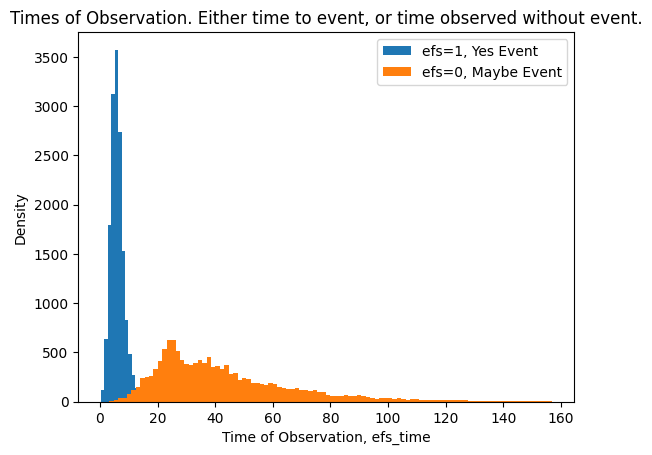

In [25]:
# ====================================================
# EDA
# ====================================================
plt.hist(train.filter(pl.col("efs") == 1)["efs_time"], bins=100, label="efs=1, Yes Event")
plt.hist(train.filter(pl.col("efs") == 0)["efs_time"], bins=100, label="efs=0, Maybe Event")
plt.xlabel("Time of Observation, efs_time")
plt.ylabel("Density")
plt.title("Times of Observation. Either time to event, or time observed without event.")
plt.legend()
plt.show()


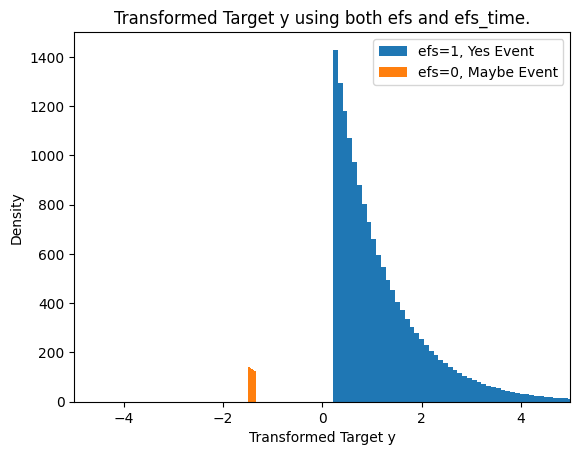

In [26]:
# ====================================================
# Transform two targets into one target
# ====================================================
mx = train.filter(pl.col("efs") == 1)["efs_time"].max()
mn = train.filter(pl.col("efs") == 0)["efs_time"].min()
train = (
    train.with_columns(
        pl.when(pl.col("efs") == 0).then(pl.col("efs_time") + mx - mn).otherwise(pl.col("efs_time")).alias("y")
    )
    .with_columns(pl.col("y").rank())
    .with_columns(pl.when(pl.col("efs") == 0).then(pl.col("y") + (2 * train.height)).otherwise(pl.col("y")))
    .with_columns(pl.col("y") / pl.col("y").max())
    .with_columns(pl.col("y").log())
    .with_columns(pl.col("y") - pl.col("y").mean())
    .with_columns(pl.col("y") * -1.0)
)

plt.hist(train.filter(pl.col("efs") == 1)["y"], bins=100, label="efs=1, Yes Event")
plt.hist(train.filter(pl.col("efs") == 0)["y"], bins=100, label="efs=0, Maybe Event")
plt.xlim((-5, 5))
plt.xlabel("Transformed Target y")
plt.ylabel("Density")
plt.title("Transformed Target y using both efs and efs_time.")
plt.legend()
plt.show()


In [27]:
# ====================================================
# Make fold column
# ====================================================
# # race_group_efs列を作成
# train = train.with_columns((pl.col("race_group").cast(str) + "_" + pl.col("efs").cast(str)).alias("race_group_efs"))

# fold_array = np.zeros(train.height)
# skf = StratifiedKFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.SEED)
# for fold, (_, val_idx) in enumerate(skf.split(train, train[CFG.stratified_col]), start=1):
#     fold_array[val_idx] = fold
# train = train.with_columns(pl.Series(fold_array, dtype=pl.Int8).alias("fold")).drop(CFG.stratified_col)

fold_array = np.zeros(train.height)
kf = KFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.SEED)
for fold, (_, val_idx) in enumerate(kf.split(train), start=1):
    fold_array[val_idx] = fold
train = train.with_columns(pl.Series(fold_array, dtype=pl.Int8).alias("fold"))


In [28]:
# ====================================================
# To pandas
# ====================================================
train = train.to_pandas()
test = test.to_pandas()


In [29]:
# ====================================================
# Features
# ====================================================
RMV = ["ID", "efs", "efs_time", "y", "fold"]
FEATURES = [c for c in train.columns if c not in RMV]
print(f"There are {len(FEATURES)} FEATURES: {FEATURES}")


There are 57 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10']


In [30]:
CATS = []
for c in FEATURES:
    if train[c].dtype == "object":
        train[c] = train[c].fillna("NAN")
        test[c] = test[c].fillna("NAN")
        CATS.append(c)
    elif "age" not in c:
        train[c] = train[c].astype("str")
        test[c] = test[c].astype("str")
        CATS.append(c)
print(f"In these features, there are {len(CATS)} CATEGORICAL FEATURES: {CATS}")


In these features, there are 55 CATEGORICAL FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10']


In [31]:
CAT_SIZE = []
CAT_EMB = []
NUMS = []

combined = pd.concat([train, test], axis=0, ignore_index=True)

print("We LABEL ENCODE the CATEGORICAL FEATURES: ")

for c in FEATURES:
    if c in CATS:  # カテゴリカル変数の処理
        # カテゴリ値を連続した整数値に変換（ラベルエンコーディング）
        combined[c], _ = combined[c].factorize()
        # 0始まりの連続した整数値になるように調整
        combined[c] -= combined[c].min()
        # メモリ効率化のためint32に変換
        combined[c] = combined[c].astype("int32")

        # カテゴリの統計情報を取得
        n = combined[c].nunique()
        mn = combined[c].min()
        mx = combined[c].max()
        print(f"{c} has ({n}) unique values")

        # 埋め込み層の設定を保存
        CAT_SIZE.append(mx + 1)  # カテゴリの種類数
        CAT_EMB.append(int(np.ceil(np.sqrt(mx + 1))))  # 埋め込み次元数（カテゴリ数の平方根）
        # CAT_EMB.append(min(50, (mx + 1) // 2))
    else:  # 数値変数の処理
        # メモリ効率化のためのデータ型変換
        if combined[c].dtype == "float64":
            combined[c] = combined[c].astype("float32")
        if combined[c].dtype == "int64":
            combined[c] = combined[c].astype("int32")

        # 標準化（平均0、標準偏差1に）
        m = combined[c].mean()
        s = combined[c].std()
        combined[c] = (combined[c] - m) / (s + 1e-6)
        # 欠損値を0で補完（標準化後の0は平均値を意味する）
        combined[c] = combined[c].fillna(0)

        NUMS.append(c)

# 前処理済みデータを学習用とテスト用に再分割
train = combined.iloc[: len(train)].copy()
test = combined.iloc[len(train) :].reset_index(drop=True).copy()


We LABEL ENCODE the CATEGORICAL FEATURES: 
dri_score has (12) unique values
psych_disturb has (4) unique values
cyto_score has (8) unique values


diabetes has (4) unique values
hla_match_c_high has (4) unique values
hla_high_res_8 has (8) unique values
tbi_status has (8) unique values
arrhythmia has (4) unique values
hla_low_res_6 has (6) unique values
graft_type has (2) unique values
vent_hist has (3) unique values
renal_issue has (4) unique values
pulm_severe has (4) unique values
prim_disease_hct has (18) unique values
hla_high_res_6 has (7) unique values
cmv_status has (5) unique values
hla_high_res_10 has (9) unique values
hla_match_dqb1_high has (4) unique values
tce_imm_match has (9) unique values
hla_nmdp_6 has (6) unique values
hla_match_c_low has (4) unique values
rituximab has (3) unique values
hla_match_drb1_low has (3) unique values
hla_match_dqb1_low has (4) unique values
prod_type has (2) unique values
cyto_score_detail has (6) unique values
conditioning_intensity has (7) unique values
ethnicity has (4) unique values
year_hct has (13) unique values
obesity has (4) unique values
mrd_hct has (3) unique values
in_viv

In [45]:
# ====================================================
# Dataset Definition
# ====================================================
class TabularDataset(Dataset):
    def __init__(self, cat_features, num_features, targets=None):
        self.cat_features = torch.tensor(cat_features, dtype=torch.long)
        self.num_features = torch.tensor(num_features, dtype=torch.float32)
        if targets is not None:
            assert len(targets.shape) == 2, f"targets must be 2D, but got {targets.shape}"
            self.targets = torch.tensor(targets, dtype=torch.float32)
        else:
            self.targets = None

    def __len__(self):
        return len(self.cat_features)

    def __getitem__(self, idx):
        if self.targets is not None:
            return self.cat_features[idx], self.num_features[idx], self.targets[idx]
        else:
            return self.cat_features[idx], self.num_features[idx]


In [41]:
# ====================================================
# Model Definition
# ====================================================
class TabularMLP(nn.Module):
    def __init__(self, cat_sizes, cat_emb_dims, num_features):
        super().__init__()

        # カテゴリカル特徴量の埋め込み層
        self.embeddings = nn.ModuleList(
            [nn.Embedding(cat_size, emb_dim) for cat_size, emb_dim in zip(cat_sizes, cat_emb_dims)]
        )

        # 埋め込みと数値特徴量を結合した後の入力サイズを計算
        total_emb_dim = sum(cat_emb_dims) + num_features

        # MLP Layer
        self.mlp = nn.Sequential(
            nn.Linear(total_emb_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
        )

    def forward(self, x_cat, x_num):
        # カテゴリカル特徴量の埋め込み
        embs = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]

        # 全ての埋め込みを結合
        x = torch.cat(embs + [x_num], dim=1)

        # MLP Layer
        x = self.mlp(x)
        return x


In [42]:
# # model summary
# model = TabularMLP(CAT_SIZE, CAT_EMB, len(NUMS))
# summary(
#     model,
#     input_size=[
#         (CFG.batch_size, len(CATS)),
#         (CFG.batch_size, len(NUMS)),
#     ],
#     dtypes=[torch.long, torch.float],
#     device="cuda",
# )


In [46]:
# ====================================================
# Train Model
# ====================================================
if CFG.DRY_RUN:
    train = train.sample(100)

oof_preds = np.zeros(len(train))
test_preds = np.zeros(len(test))

for fold in range(1, CFG.n_folds + 1):
    print("#" * 25)
    print(f"        Fold {fold}/{CFG.n_folds}")
    print("#" * 25)

    # create dataset
    train_dataset = TabularDataset(
        train.loc[train["fold"] != fold, CATS].to_numpy(),
        train.loc[train["fold"] != fold, NUMS].to_numpy(),
        train.loc[train["fold"] != fold, "y"].to_numpy().reshape(-1, 1),
    )
    val_dataset = TabularDataset(
        train.loc[train["fold"] == fold, CATS].to_numpy(),
        train.loc[train["fold"] == fold, NUMS].to_numpy(),
        train.loc[train["fold"] == fold, "y"].to_numpy().reshape(-1, 1),
    )
    test_dataset = TabularDataset(test[CATS].to_numpy(), test[NUMS].to_numpy())

    # create dataloader
    train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=2, pin_memory=True)

    # model, criterion, optimizer, scheduler
    model = TabularMLP(cat_sizes=CAT_SIZE, cat_emb_dims=CAT_EMB, num_features=len(NUMS))
    model.to(CFG.device)
    criterion = nn.MSELoss()
    # optimizer = AdamW(model.parameters(), lr=CFG.lr)
    optimizer = Adam(model.parameters(), lr=CFG.lr)
    num_training_steps = len(train_loader) * CFG.epochs
    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_training_steps=num_training_steps,
        num_warmup_steps=num_training_steps // 10,
    )

    best_loss = np.inf

    train_losses = []
    valid_losses = []

    # train
    for epoch in range(CFG.epochs):
        print(f"\nEpoch {epoch+1}/{CFG.epochs}")
        # train
        model.train()
        epoch_train_losses = []  # エポックごとの訓練損失を保存
        for cat_features, num_features, targets in train_loader:
            cat_features = cat_features.to(CFG.device)
            num_features = num_features.to(CFG.device)
            targets = targets.to(CFG.device)

            optimizer.zero_grad()
            outputs = model(cat_features, num_features)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()

            epoch_train_losses.append(loss.item())  # バッチごとの損失を保存
        # エポックの平均訓練損失を計算
        train_loss = np.mean(epoch_train_losses)
        train_losses.append(train_loss)

        # validation
        model.eval()
        val_losses = []
        with torch.no_grad():
            for cat_features, num_features, targets in val_loader:
                cat_features = cat_features.to(CFG.device)
                num_features = num_features.to(CFG.device)
                targets = targets.to(CFG.device)

                outputs = model(cat_features, num_features)
                loss = criterion(outputs, targets)
                val_losses.append(loss.item())

        val_loss = np.mean(val_losses)
        valid_losses.append(val_loss)
        print(f"Validation loss: {val_loss:.4f}")

        # save best model
        if val_loss < best_loss:
            best_loss = val_loss
            save_model_path = (
                CFG.MODEL_PATH / f"nn_{CFG.target_col}_fold{fold}_seed{CFG.SEED}_ver{CFG.EXP_NAME}.pth"
            )
            save_model_path.parent.mkdir(parents=True, exist_ok=True)
            torch.save(model.state_dict(), save_model_path)
            print("Best model saved")

    # oof
    model.load_state_dict(
        torch.load(CFG.MODEL_PATH / f"nn_{CFG.target_col}_fold{fold}_seed{CFG.SEED}_ver{CFG.EXP_NAME}.pth")
    )
    model.eval()
    predictions = []
    with torch.no_grad():
        for cat_features, num_features, _ in val_loader:
            cat_features = cat_features.to(CFG.device)
            num_features = num_features.to(CFG.device)
            outputs = model(cat_features, num_features)
            predictions.extend(outputs.cpu().numpy())

    val_idx = train["fold"] == fold
    oof_preds[val_idx] = np.concatenate(predictions)

    # test
    predictions = []
    with torch.no_grad():
        for cat_features, num_features in test_loader:
            cat_features = cat_features.to(CFG.device)
            num_features = num_features.to(CFG.device)
            outputs = model(cat_features, num_features)
            predictions.extend(outputs.cpu().numpy())

    test_preds += np.concatenate(predictions) / CFG.n_folds

    # break


#########################
        Fold 1/5
#########################

Epoch 1/5


Validation loss: 1.9195
Best model saved

Epoch 2/5
Validation loss: 1.8619
Best model saved

Epoch 3/5
Validation loss: 1.8275
Best model saved

Epoch 4/5
Validation loss: 1.8296

Epoch 5/5
Validation loss: 1.8253
Best model saved
#########################
        Fold 2/5
#########################

Epoch 1/5
Validation loss: 1.9483
Best model saved

Epoch 2/5
Validation loss: 1.8350
Best model saved

Epoch 3/5
Validation loss: 1.8323
Best model saved

Epoch 4/5
Validation loss: 1.8185
Best model saved

Epoch 5/5
Validation loss: 1.8211
#########################
        Fold 3/5
#########################

Epoch 1/5
Validation loss: 1.8830
Best model saved

Epoch 2/5
Validation loss: 1.8643
Best model saved

Epoch 3/5
Validation loss: 1.8454
Best model saved

Epoch 4/5
Validation loss: 1.8418
Best model saved

Epoch 5/5
Validation loss: 1.8669
#########################
        Fold 4/5
#########################

Epoch 1/5
Validation loss: 2.0048
Best model saved

Epoch 2/5
Validation l

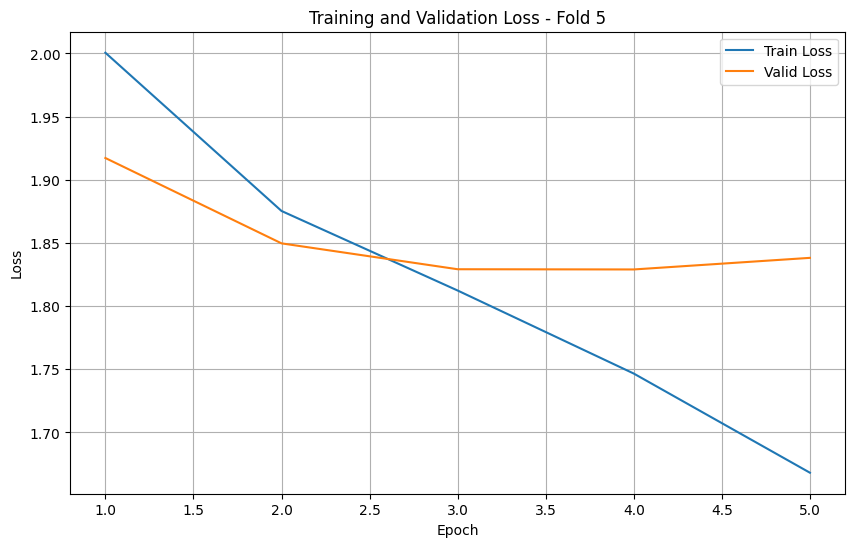

In [47]:
# エポック終了後に損失の推移をプロット
plt.figure(figsize=(10, 6))
plt.plot(range(1, CFG.epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, CFG.epochs + 1), valid_losses, label="Valid Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Training and Validation Loss - Fold {fold}")
plt.legend()
plt.grid(True)
plt.show()
